# Practical Machine Learning for Physicists

In this notebook I will attempt to implement two bottlenecks autoencoders, one with a bottleneck containing 9 neurons, and one with a 3-neurons bottleneck. The maximum amount of samples (steps * batchsize) is of 30000. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

plt.style.use('ggplot')

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.3.0


In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## 9 neurons bottleneck

I will follow here a similar pipeline to the other week4-notebook: "Week4_MNIST_CNN" to fine-tune the hyperparameters for the network. 
The only requirement we have here is that the bottleneck has 9 neurons in total. 

This will be achieved by a middle layer with dimensions  (batchsize, 3, 3, 1), where batchsize must be chosen to respect the limit of 30000 max samples. In the dimensions, 3x3 is the size of the image, and 1 means that we will reach a map size of 1. To achieve this, we will start by having a higher number of output maps, and then scaling down using pooling until reaching the required size.

### Choosing Map Size
We will start by exploring this question. The convolutional layer in fact could have 8, 16, 24, 32, etc. feature maps, and this hyperparameter must be correctly tuned.

In [4]:
iterations = 4 #selecting number of models to iterate on
model = [0] *iterations #creating a list with 6 zeros  

for j in range(iterations): #iterating over different feature maps
    model[j] = keras.models.Sequential()
    model[j].add(keras.layers.Conv2D(j*4+4,kernel_size=5,activation='relu',input_shape=(None,None,1))) # convolutional layer
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same')) #reducing image size with pooling
    model[j].add(keras.layers.Conv2D(j*6 + 6,kernel_size=5,padding='same',activation='relu')) # convolutional layer
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))#reducing image size with pooling
    model[j].add(keras.layers.Conv2D(1,3,
                activation="relu",padding='same')) # convolutional layer
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) #increasing image size with UpSampling
    model[j].add(keras.layers.Conv2D(j*6 + 6,5,
                activation="relu",padding='same')) # convolutional layer
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) #increasing image size with UpSampling
    model[j].add(keras.layers.Conv2D(j*4+4,5,
                activation="relu",padding='same'))# convolutional layer
    model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))# convolutional layer

    model[j].compile(loss='mean_squared_error', optimizer='adam')
    



Network 4 maps (1st layer): Final Cost = 0.03932
Network 8 maps (1st layer): Final Cost = 0.02757
Network 12 maps (1st layer): Final Cost = 0.01694
Network 16 maps (1st layer): Final Cost = 0.01539


Text(0.5, 1.0, 'model cost')

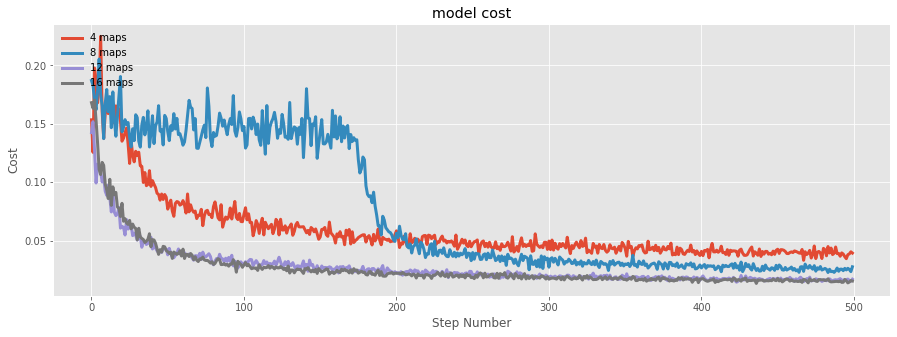

In [5]:
steps=500 #setting the steps number 
#creating plot and defining labels
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
names = [] #initialising a list

stepArray=np.arange(steps) #initialising the array for the x axis in the plot

#Plot the cost
for j in range(iterations): #iterating
    cost,y_target=generate_and_train(model[j],circle_generator,img_size=9*3,batchsize=60,steps=steps) #Generate the cost functions
    ax.plot(stepArray,cost,linewidth=3)  #plot
    print("Network %1.0f maps (1st layer): Final Cost = %2.5f"%(j*4+4,cost[-1])) #print final cost
    names.append(str("%1.0f maps")%(j*4+4))
    
plt.legend(names, loc='upper left')
plt.title('model cost')




It is clear that a first network with 4 maps is strongly inferior. 12 and 16 maps are clearly superior, and therefore we will use 16 maps for the sake of the assignment. 

### Choosing Kernel Size
The kernel could be (3,3) , (5,5) , (7,7) etc. Different sizes can be used to extract image features of different size, and therefore it is usually chosen according to the expected feature size in the image. 
In this case we could iterate between these three kernel sizes to see which one is most suitable.

In [6]:
iterations = 3 #selecting number of models to iterate on
model = [0] *iterations #creating a list with 6 zeros  

for j in range(iterations): #iterating over different feature maps

    #creating the same network architecture, but this time we iterate over the kernel size,
    # and we set the values of map sizes to the best values found above    
    model[j] = keras.models.Sequential()
    model[j].add(keras.layers.Conv2D(16,kernel_size=j*2 + 3,activation='relu',input_shape=(None,None,1)))
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))
    model[j].add(keras.layers.Conv2D(24,kernel_size=j*2 + 3,padding='same',activation='relu'))
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))
    model[j].add(keras.layers.Conv2D(1,3,
                activation="relu",padding='same'))
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) 
    model[j].add(keras.layers.Conv2D(24,kernel_size=j*2 + 3,
                activation="relu",padding='same'))
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) 
    model[j].add(keras.layers.Conv2D(16,kernel_size=j*2 + 3,
                activation="relu",padding='same'))
    model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))

    model[j].compile(loss='mean_squared_error', optimizer='adam')
    


Network 3 kernel size: Final Cost = 0.01946
Network 5 kernel size: Final Cost = 0.01796
Network 7 kernel size: Final Cost = 0.01249


Text(0.5, 1.0, 'model cost')

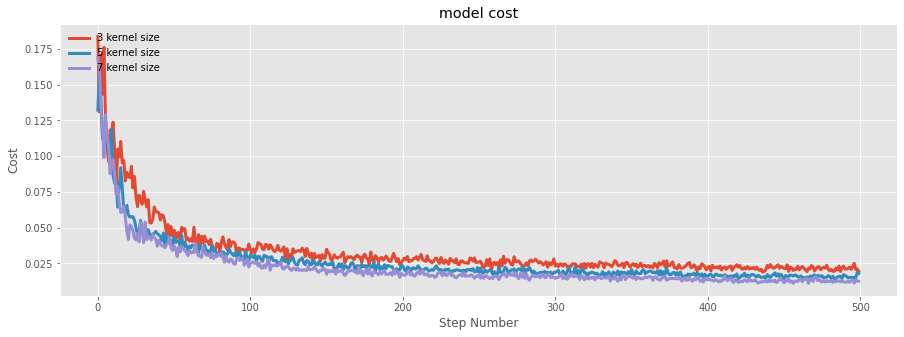

In [7]:
#preparing the plo
steps=500
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
names = []
stepArray=np.arange(steps) 

#Plot the cost
for j in range(iterations): #iterating
    cost,y_target=generate_and_train(model[j],circle_generator,img_size=9*3,batchsize=60,steps=steps) #generating costs
    ax.plot(stepArray,cost,linewidth=3) #plotting
    print("Network %1.0f kernel size: Final Cost = %2.5f"%(j*2 + 3,cost[-1])) #printing costs
    names.append(str("%1.0f kernel size")%(j*2 + 3))
    
plt.legend(names, loc='upper left')
plt.title('model cost')


It seems here that a kernel size of 7 is the optimal one to detect all the necessary features. 

### Setting the batchsize and step number

Considering the limit of 30000 samples, there is a tradeoff between batchsize and steps number. Again we can iterate to find the most suitable value. 

We shall therefore iterate between different batchsizes and steps values. 

Firstly we define the network architecture.


In [8]:
def final_model():
    """
    Function that defines the final network architecture, we the best hyperparameters found above
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(16,kernel_size=7,activation='relu',input_shape=(None,None,1))) #convolutional layer
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))
    model.add(keras.layers.Conv2D(24,kernel_size=7,padding='same',activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))
    model.add(keras.layers.Conv2D(1,3,
                activation="relu",padding='same'))
    model.add(keras.layers.UpSampling2D(size=(3,3))) # up
    model.add(keras.layers.Conv2D(24,kernel_size=7,
                activation="relu",padding='same'))
    model.add(keras.layers.UpSampling2D(size=(3,3))) # up
    model.add(keras.layers.Conv2D(16,kernel_size=7,
                activation="relu",padding='same'))
    model.add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


In [9]:
batchsize = [30, 60, 100, 300, 1000] #choosing a list of possible batch-sizes
stepArray=np.arange(steps) 
#Plot the cost
for j in batchsize: #iterating
    model = final_model()
    
    batchsize = j # using mentioned formulas
    steps=int(30000/batchsize) #making sure they don't exceed 30000 samples

    cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=batchsize,steps=steps) #Plot the cost
    print("Network batchsize %1.2f : Final Cost = %2.5f"%(j,cost[-1]))
    


Network batchsize 30.00 : Final Cost = 0.00948
Network batchsize 60.00 : Final Cost = 0.14811
Network batchsize 100.00 : Final Cost = 0.01736
Network batchsize 300.00 : Final Cost = 0.15566
Network batchsize 1000.00 : Final Cost = 0.06630


Clearly there is a minimum around batchsize [30,100], let's explore further:

In [10]:
batchsize = np.linspace(30, 100, 6) #zooming into the desired interval of batchsizes
stepArray=np.arange(steps) 
#Plot the cost
for j in batchsize: #iterating
    model = final_model()
    
    batchsize = int(j) # using value of batchsize from the linspace function
    steps=int(30000/batchsize)

    cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=batchsize,steps=steps) #Plot the cost
    print("Network batchsize %1.2f : Final Cost = %2.5f"%(j,cost[-1]))
    


Network batchsize 30.00 : Final Cost = 0.00874
Network batchsize 44.00 : Final Cost = 0.00945
Network batchsize 58.00 : Final Cost = 0.01166
Network batchsize 72.00 : Final Cost = 0.01600
Network batchsize 86.00 : Final Cost = 0.01473
Network batchsize 100.00 : Final Cost = 0.01550


It seems that the best combination is around the value of batchsize 50, so we will use this, with a respective step value of 600.

The last model can therefore be tested below.

### Final Architecture

The final architecture for the 9-neurons bottleneck network is therefore:

0.013644681312143803


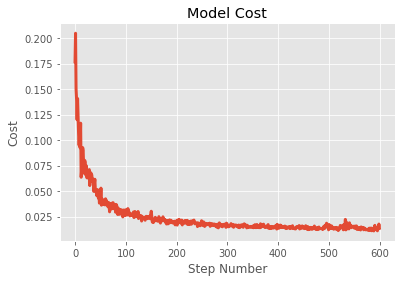

In [11]:
model = final_model()

#Now we can do the actual model training
steps=600
cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=50,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
plt.title('Model Cost')
print(cost[-1])

The final cost is therefore significantly below the 0.02 target of the cost function, with a value of 0.013.

The reproduced image is shown below, and it clearly resembles the initial image, with slightly less resolution. 

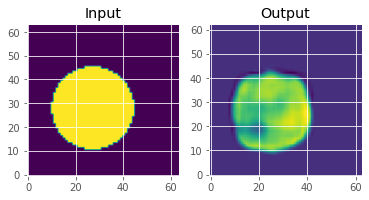

In [12]:
#Reproducing image 
plot_test_image(model,circle_generator,64)

And it can be verified that the central layer has 9 neurons here. 

In [13]:
print_layers(model,y_target)

Layer 0: 7056 neurons /  (50, 21, 21, 16)
Layer 1: 784 neurons /  (50, 7, 7, 16)
Layer 2: 1176 neurons /  (50, 7, 7, 24)
Layer 3: 216 neurons /  (50, 3, 3, 24)
Layer 4: 9 neurons /  (50, 3, 3, 1)
Layer 5: 81 neurons /  (50, 9, 9, 1)
Layer 6: 1944 neurons /  (50, 9, 9, 24)
Layer 7: 17496 neurons /  (50, 27, 27, 24)
Layer 8: 11664 neurons /  (50, 27, 27, 16)
Layer 9: 729 neurons /  (50, 27, 27, 1)


The first autoencoder was therefore a success. Let's take a look at the second model.

## 3 neurons bottleneck

We can apply the same exact procedure to the 3 neurons bottleneck case. This time however to reach a 3 neurons bottleneck, we will reach a central layer with dimensions (batchsize, 1, 1, 3), so we need to have a map size of 3 and image dimension of 1x1. 

### Choosing Map Size

In the cell below there is an example of autoencoder with 3-neurons bottleneck. This can be constructed by carefully adding layers until reaching a dimension of (batchsize, 1,1,3) in the central layer. 

How to do this? 
First scale up the map size with one convolutional layer and then add a pooling layer to reduce the image pixel size. Repeat with other convolutional layers and pooling layers until you reach a pixel value of 1 for the image and a map size of 3. 

I will keep track of the sizes in the comments of the code. 

In [14]:
iterations = 7 #selecting number of models to iterate on
model = [0] *iterations #creating a list with 6 zeros  

for j in range(iterations): #iterating over different feature maps
    model[j] = keras.models.Sequential()
    model[j].add(keras.layers.Conv2D(j*6+6,kernel_size=5,activation='relu',input_shape=(None,None,1))) #size: (batchsize, 27, 27, j*6 + 6 )
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same')) # image size reduction
    model[j].add(keras.layers.Conv2D(j*4 + 4,kernel_size=5,padding='same',activation='relu')) #size: (batchsize, 9, 9, j*4 + 4 )
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))  # image size reduction
    model[j].add(keras.layers.Conv2D(3,kernel_size=3,
                activation="relu",padding='same')) #size: (batchsize, 3, 3, 3 )
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same')) #image size reduction: final size: (batchsize, 1,1,3)
    
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model[j].add(keras.layers.Conv2D(j*4 + 4,kernel_size=5,
                activation="relu",padding='same')) #size: (batchsize, 9, 9, j*4 + 4 )
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model[j].add(keras.layers.Conv2D(j*6+6,kernel_size=5,
                activation="relu",padding='same')) #size: (batchsize, 27, 27, j*6 + 6 )
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model[j].add(keras.layers.Conv2D(1,kernel_size=3,activation="linear",padding='same')) #size: (batchsize, 27, 27, 1) ->> came back to normal

    model[j].compile(loss='mean_squared_error', optimizer='adam')

Network 6 maps (1st layer): Final Cost = 0.03754
Network 12 maps (1st layer): Final Cost = 0.03433
Network 18 maps (1st layer): Final Cost = 0.03261
Network 24 maps (1st layer): Final Cost = 0.02859
Network 30 maps (1st layer): Final Cost = 0.02485
Network 36 maps (1st layer): Final Cost = 0.02589
Network 42 maps (1st layer): Final Cost = 0.02369


Text(0.5, 1.0, 'model cost')

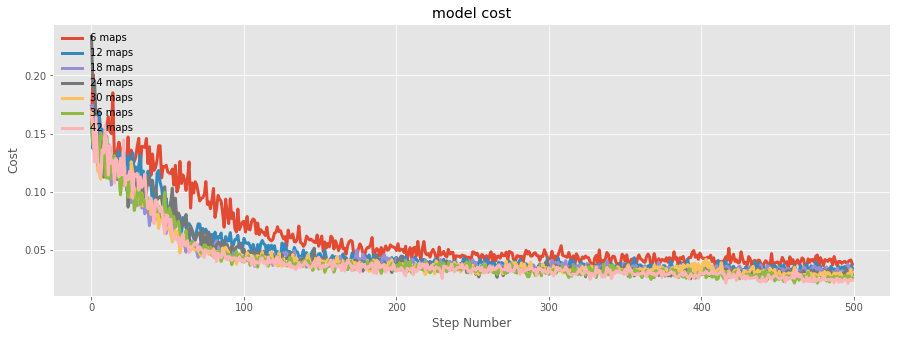

In [15]:
steps=500
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
names = []

stepArray=np.arange(steps) 
#Plot the cost
for j in range(iterations): #iterating
    cost,y_target=generate_and_train(model[j],circle_generator,img_size=9*3,batchsize=60,steps=steps) #Plot the cost
    ax.plot(stepArray,cost,linewidth=3) 
    print("Network %1.0f maps (1st layer): Final Cost = %2.5f"%(j*6+6,cost[-1]))
    names.append(str("%1.0f maps")%(j*6+6))
    
plt.legend(names, loc='upper left')
plt.title('model cost')


It seems that 30 maps size in the first layer gives the lowest cost function. 

### Choosing Kernel Size

Best one between 3,5,7 and 9?

In [20]:
iterations = 4 #selecting number of models to iterate on
model = [0] *iterations #creating a list with 6 zeros  

for j in range(iterations): #iterating over different feature maps
    model[j] = keras.models.Sequential()
    model[j].add(keras.layers.Conv2D(30,kernel_size=2*j + 3,activation='relu',input_shape=(None,None,1))) #down
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same')) # image size reduction
    model[j].add(keras.layers.Conv2D(20,kernel_size=2*j + 3,padding='same',activation='relu')) #down
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))  # image size reduction
    model[j].add(keras.layers.Conv2D(3,kernel_size=3,
                activation="relu",padding='same')) #down
    model[j].add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same')) #image size reduction: final size: (batchsize, 1,1,3)
    
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model[j].add(keras.layers.Conv2D(20,kernel_size=3,
                activation="relu",padding='same')) #up
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model[j].add(keras.layers.Conv2D(30,kernel_size=2*j + 3,
                activation="relu",padding='same')) #up
    model[j].add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model[j].add(keras.layers.Conv2D(1,kernel_size=2*j + 3,activation="linear",padding='same')) #size: (batchsize, 27, 27, 1) ->> came back to normal

    model[j].compile(loss='mean_squared_error', optimizer='adam')

Network 3 kernel size (first layer): Final Cost = 0.03779
Network 5 kernel size (first layer): Final Cost = 0.02805
Network 7 kernel size (first layer): Final Cost = 0.02182
Network 9 kernel size (first layer): Final Cost = 0.01971


Text(0.5, 1.0, 'model cost')

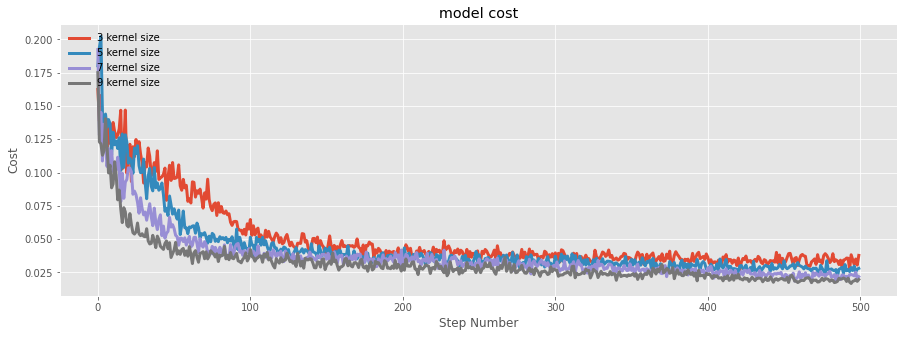

In [21]:
steps=500
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
names = []

stepArray=np.arange(steps) 
#Plot the cost
for j in range(iterations): #iterating
    cost,y_target=generate_and_train(model[j],circle_generator,img_size=9*3,batchsize=60,steps=steps) #Plot the cost
    ax.plot(stepArray,cost,linewidth=3) 
    print("Network %1.0f kernel size (first layer): Final Cost = %2.5f"%(j*2 + 3,cost[-1]))
    names.append(str("%1.0f kernel size")%(j*2 + 3))
    
plt.legend(names, loc='upper left')
plt.title('model cost')


We will therefore choose a kernel size of 5, as it is most stable among several runs of the past cell.

### Choosing Batchsize and Steps Number

In [22]:
def final_model_3N():

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(30,kernel_size=5,activation='relu',input_shape=(None,None,1))) #size: (batchsize, 27, 27, j*6 + 6 )
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same')) # image size reduction
    model.add(keras.layers.Conv2D(20,kernel_size=5,padding='same',activation='relu')) #size: (batchsize, 9, 9, j*4 + 4 )
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same'))  # image size reduction
    model.add(keras.layers.Conv2D(3,kernel_size=3,
                activation="relu",padding='same')) #size: (batchsize, 3, 3, 3 )
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),padding='same')) #image size reduction: final size: (batchsize, 1,1,3)
    
    model.add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model.add(keras.layers.Conv2D(20,kernel_size=3,
                activation="relu",padding='same')) #size: (batchsize, 9, 9, j*4 + 4 )
    model.add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model.add(keras.layers.Conv2D(30,kernel_size=5,
                activation="relu",padding='same')) #size: (batchsize, 27, 27, j*6 + 6 )
    model.add(keras.layers.UpSampling2D(size=(3,3))) # image size increase
    model.add(keras.layers.Conv2D(1,kernel_size=5,activation="linear",padding='same')) #size: (batchsize, 27, 27, 1) ->> came back to normal
    model.compile(loss='mean_squared_error', optimizer='adam')


    return model


In [23]:
batchsize = np.linspace(30,100,6)
stepArray=np.arange(steps) 
#Plot the cost
for j in batchsize: #iterating
    model = final_model_3N()
    
    batchsize = int(j) # using mentioned formulas
    steps=int(30000/batchsize)

    cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=batchsize,steps=steps) #Plot the cost
    print("Network batchsize %1.2f : Final Cost = %2.5f"%(j,cost[-1]))
    


Network batchsize 30.00 : Final Cost = 0.01929
Network batchsize 44.00 : Final Cost = 0.02091
Network batchsize 58.00 : Final Cost = 0.02592
Network batchsize 72.00 : Final Cost = 0.02393
Network batchsize 86.00 : Final Cost = 0.03227
Network batchsize 100.00 : Final Cost = 0.03099


I will therefore use a batchsize of 50 and 600 steps.

### Final Architecture

0.022906269878149033


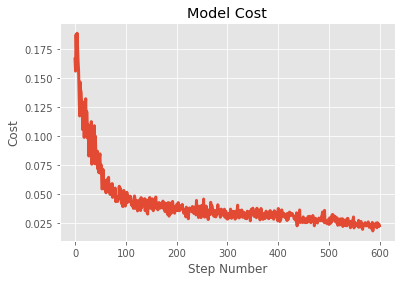

In [24]:
model = final_model_3N()

#Now we can do the actual model training
steps=600
cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=50,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
plt.title('Model Cost')
print(cost[-1])

The final architecture sees a fairly low cost function, of approximately 0.022. 

Below we can check the output image:

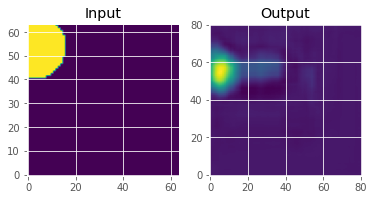

In [25]:
#And now when we look our model is probably doing a much better job of reproducing the image
plot_test_image(model,circle_generator,64);

To ensure that the central layer is in the correct size, check the print layers function below:

In [26]:
print_layers(model,y_target)

Layer 0: 15870 neurons /  (50, 23, 23, 30)
Layer 1: 1920 neurons /  (50, 8, 8, 30)
Layer 2: 1280 neurons /  (50, 8, 8, 20)
Layer 3: 180 neurons /  (50, 3, 3, 20)
Layer 4: 27 neurons /  (50, 3, 3, 3)
Layer 5: 3 neurons /  (50, 1, 1, 3)
Layer 6: 27 neurons /  (50, 3, 3, 3)
Layer 7: 180 neurons /  (50, 3, 3, 20)
Layer 8: 1620 neurons /  (50, 9, 9, 20)
Layer 9: 2430 neurons /  (50, 9, 9, 30)
Layer 10: 21870 neurons /  (50, 27, 27, 30)
Layer 11: 729 neurons /  (50, 27, 27, 1)
